# EDSA - Movie Recommender Challenge 2022

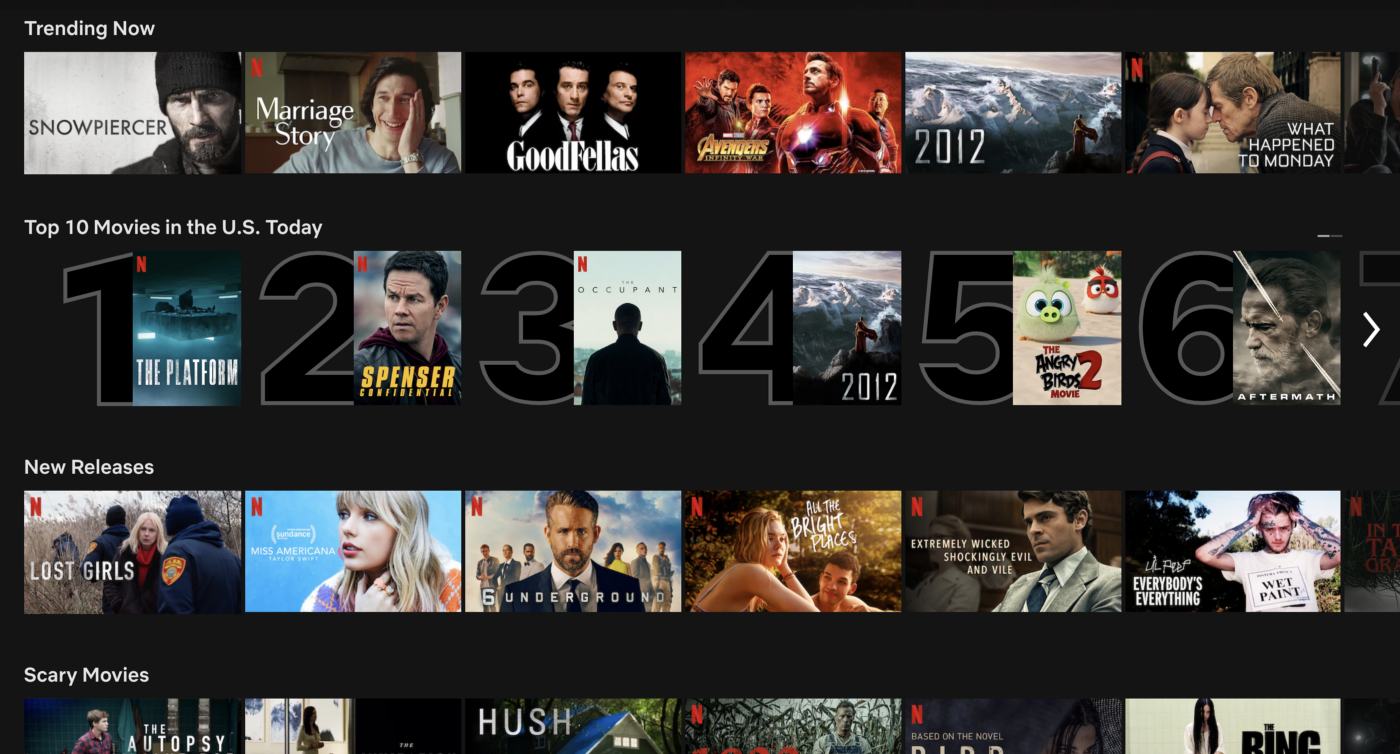

Photo by Shruti Bendale (https://medium.com/)

# 1. Introduction 

In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

## 1.1. Problem Statement

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

## 1.2. Challenge Requirements
Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being personalised recommendations - generating platform affinity for the streaming services which best facilitates their audience's viewing.

# 2. Required  Computation Libraries

In [1]:
# Libraries for importing and loading data
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
import scipy as sp 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from textwrap import wrap

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD
from surprise import SVDpp
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from sklearn.feature_extraction.text import CountVectorizer


# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists
from time import time

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Setting global constants to ensure notebook results are reproducible

RANDOM_STATE = 42

# Packages for saving models
import pickle


import warnings
warnings.filterwarnings('ignore')

## 2.1 Loading Datasets for Processing

All required datasets are collected and loaded into the Notebook for processing.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
movies = pd.read_csv('movies.csv')
imdb = pd.read_csv('imdb_data.csv')
genome_scores = pd.read_csv('genome_scores.csv')
dgenome_tags = pd.read_csv('genome_tags.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

# 3. Data Exploration: Pre-processing
Datasets are explored for their features to get their shapes before porcessing.
* data.head() - for feature exploration
* data.shape - for orientation
* data.isnull().sum - for checking all missing values


In [3]:
train.head() 


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
train.shape 

(10000038, 4)

In [5]:
train.isnull().sum

<bound method DataFrame.sum of           userId  movieId  rating  timestamp
0          False    False   False      False
1          False    False   False      False
2          False    False   False      False
3          False    False   False      False
4          False    False   False      False
...          ...      ...     ...        ...
10000033   False    False   False      False
10000034   False    False   False      False
10000035   False    False   False      False
10000036   False    False   False      False
10000037   False    False   False      False

[10000038 rows x 4 columns]>

In [6]:
#Using a for loop the compute the number of missing values in all the columns of the dataset

i = 0
for x in train.columns:
    if '' in sorted(train[x].unique()):
        i +=1
print('The data has '+str(i)+' empty values in all columns')

The data has 0 empty values in all columns


In [7]:
test.head()

,userId,movieId
0,5,788
1,68,7438
2,336,40412
3,803,3822
4,547,903


In [8]:
test.shape

(14310, 2)

In [9]:
test.isnull().sum

<bound method DataFrame.sum of        userId  movieId
0       False    False
1       False    False
2       False    False
3       False    False
4       False    False
...       ...      ...
14305   False    False
14306   False    False
14307   False    False
14308   False    False
14309   False    False

[14310 rows x 2 columns]>

In [10]:
#Using a for loop the compute the number of missing values in all the columns of the dataset

i = 0
for x in test.columns:
    if '' in sorted(test[x].unique()):
        i += 1
print('The data has '+str(i)+' empty values in all columns')

The data has 0 empty values in all columns


In [11]:
# Check for duplicated values
result = train.duplicated(['userId', 'movieId', 'rating'])

# Display Duplicated values
print("Number of duplicated values:", sum(result))

Number of duplicated values: 0


In [12]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movies.shape

(62423, 3)

In [14]:
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [15]:
imdb.shape

(27278, 6)

In [16]:
sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [17]:
sample_submission.shape

(5000019, 2)

In [18]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [19]:
genome_scores.shape

(15584448, 3)

In [20]:
dgenome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [21]:
dgenome_tags.shape

(1128, 2)

In [22]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [23]:
tags.shape

(1093360, 4)

In [24]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [25]:
links.shape

(62423, 3)

Train and Test datasets contain no missing values; datasets are clean.

# 4. Exploratory Data Analysis

In [26]:
# ceating a copies of train and movies dataset
df_train = train.copy()
df_movies = movies.copy()

In [27]:
# Concatenating movies and train tables for analysis
df_train_movies = pd.merge(df_train, df_movies, on='movieId')
df_train_movies.head(5)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [28]:
# Make a copy of movie table
df_movies = movies.copy()

# Remove delimiters from interested columns
df_movies["genres"] = df_movies["genres"].str.replace('|', ' ', regex=True)
df_movies["title"] = df_movies["title"].str.replace('(', ' ', regex=True)
df_movies["title"] = df_movies["title"].str.replace(')', ' ', regex=True)
df_movies["genres"] = df_movies["genres"].str.replace('(', ' ', regex=True)
df_movies["genres"] = df_movies["genres"].str.replace(')', ' ', regex=True)
# Create a movie year column
df_movies["year"] = df_movies["title"].str.replace(r'[a-zA-Z]', '', regex=True)
df_movies["year"] = df_movies["year"].str.replace(r' ', '', regex=True)
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story 1995,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji 1995,Adventure Children Fantasy,1995
2,3,Grumpier Old Men 1995,Comedy Romance,1995
3,4,Waiting to Exhale 1995,Comedy Drama Romance,1995
4,5,Father of the Bride Part II 1995,Comedy,1995


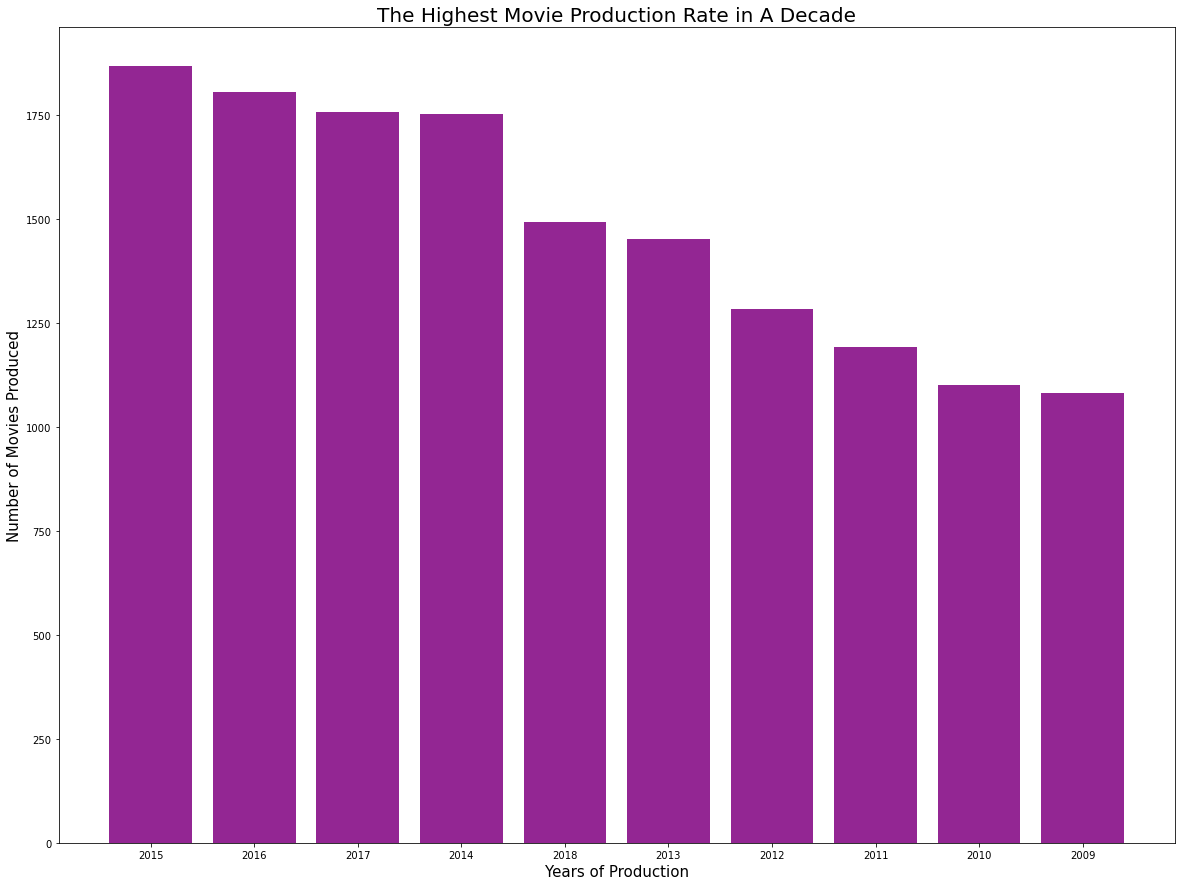

In [29]:
# Visualise the first ten years with the highest numbers of movies produced
df_movies["year"] = df_movies["year"].astype('str')
movies_year_count = df_movies["year"].value_counts()
fig, ax = plt.subplots( figsize=(20,15))
# p = sns.barplot(x=movies_year_count.index[:10], y=movies_year_count.values[:10])
ax.bar(movies_year_count.index[:10], movies_year_count.values[:10],  facecolor='purple', alpha=0.85)
ax.set_xlabel("Years of Production", fontsize = 15)
ax.set_ylabel("Number of Movies Produced", fontsize = 15)
ax.set_title("The Highest Movie Production Rate in A Decade", fontsize = 20)
plt.show()

* The ratings begin to drop from the fifth year(2018) to 2009.

In [30]:
def tokenizer(data, col):
    df = data.copy()
    tokeniser = TreebankWordTokenizer()
    df['genre_tok'] = df[col].apply(tokeniser.tokenize)
    return df 

In [31]:
# Tokenized genre column
df_movies = tokenizer(df_movies, 'genres')
df_movies.head()

,movieId,title,genres,year,genre_tok
0,1,Toy Story 1995,Adventure Animation Children Comedy Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji 1995,Adventure Children Fantasy,1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men 1995,Comedy Romance,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale 1995,Comedy Drama Romance,1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II 1995,Comedy,1995,[Comedy]


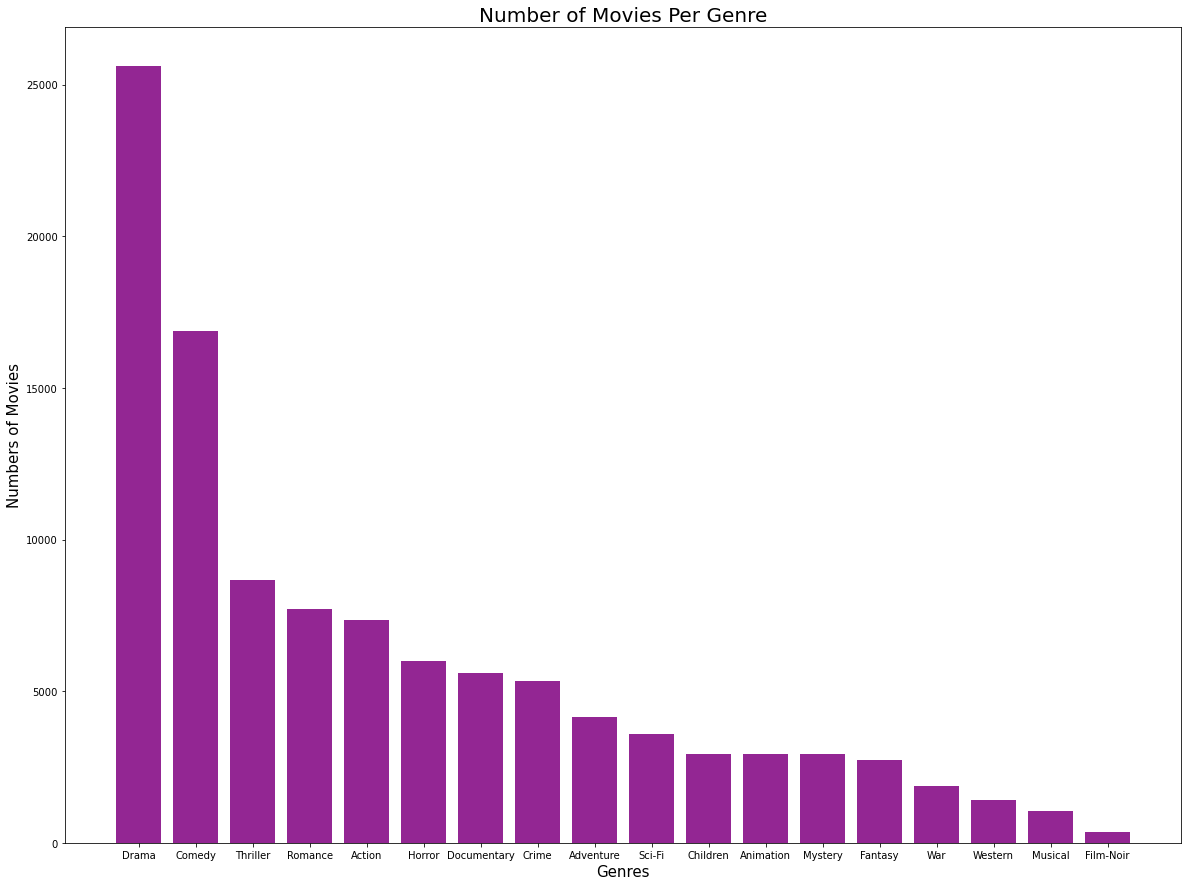

In [32]:
# Collect the tokenized genre in a list form
genres = df_movies['genre_tok'].values.tolist()
all_genres = []

# Merge the genre values
for index, genre in enumerate(genres):
    all_genres.extend(genre)

genre_df = pd.DataFrame({
    "genre":all_genres
})

genre_df = genre_df[genre_df['genre'].isin(['no', 'listed', 'genres', 'IMAX']) == False]

# Visualise the first twenty years with the highest numbers of movies produced
genre_count = genre_df["genre"].value_counts()
fig, ax = plt.subplots( figsize=(20,15))
ax.bar(genre_count.index, genre_count.values,  facecolor='purple', alpha=0.85)
ax.set_xlabel("Genres", fontsize = 15)
ax.set_ylabel("Numbers of Movies", fontsize = 15)
ax.set_title("Number of Movies Per Genre", fontsize = 20)
plt.show()

* It can be seen that top 3 genres with highest number of movies are: Drama, Comedy and Thriller respectively.

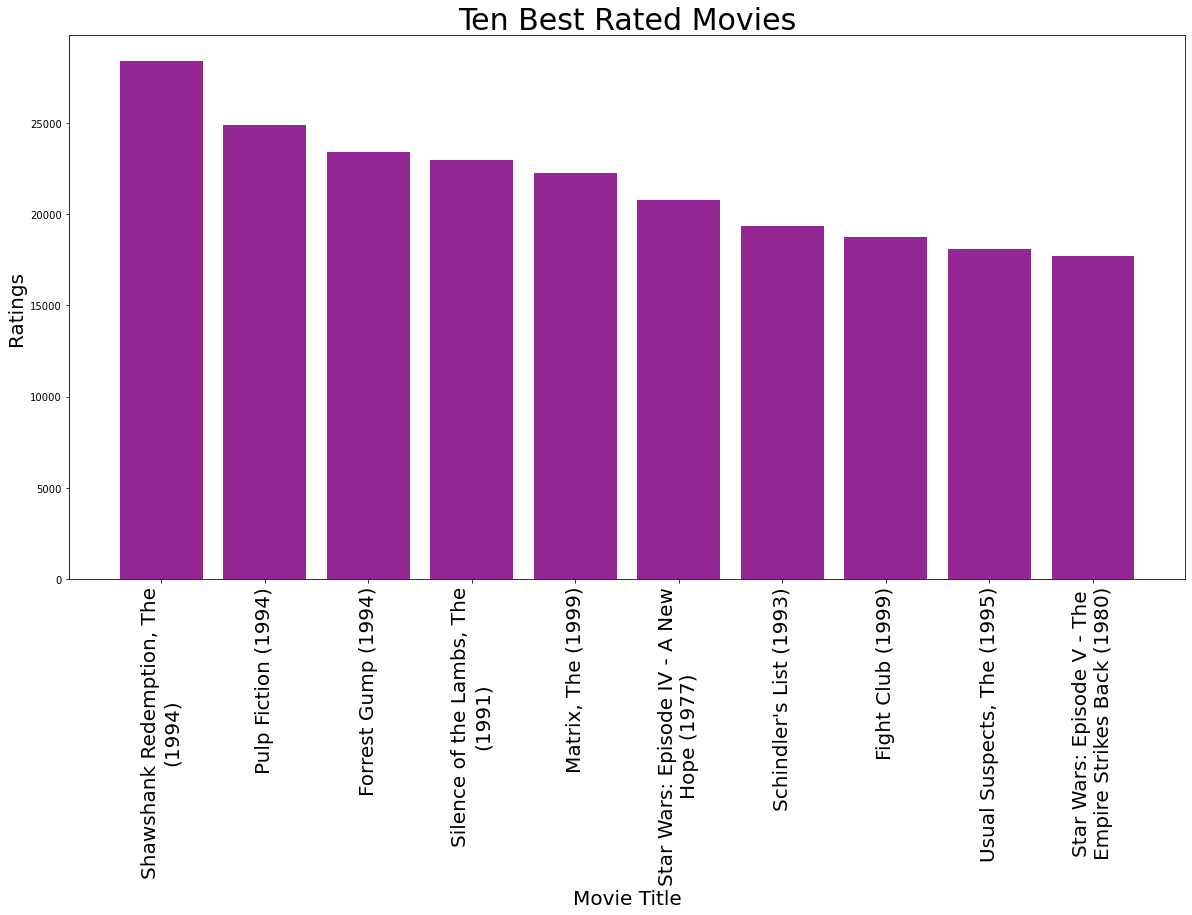

In [33]:
#Top ten best rated movies
df_train = train.copy()
df_train.drop(columns='timestamp', inplace=True)
ratings = df_train[['movieId','rating']]
ratings = ratings[ratings['rating'] > 3.9]
ratings = ratings.merge(movies, on = 'movieId', how= 'left')


movies_ratings = ratings['title'].value_counts()

labels = [ '\n'.join(wrap(l, 30)) for l in movies_ratings.index[:10]]



fig, ax = plt.subplots( figsize=(20,10))

ax.bar(labels, movies_ratings.values[:10],  color='purple', alpha=0.85, width = 0.8)
ax.set_xlabel("Movie Title", fontsize = 20)
ax.set_ylabel( "Ratings", fontsize = 20)
ax.set_title("Ten Best Rated Movies", fontsize = 30)
plt.xticks(rotation=90, fontsize= 20)
plt.show()

 * 1994 has three best rated movies as depicted by the chart above.

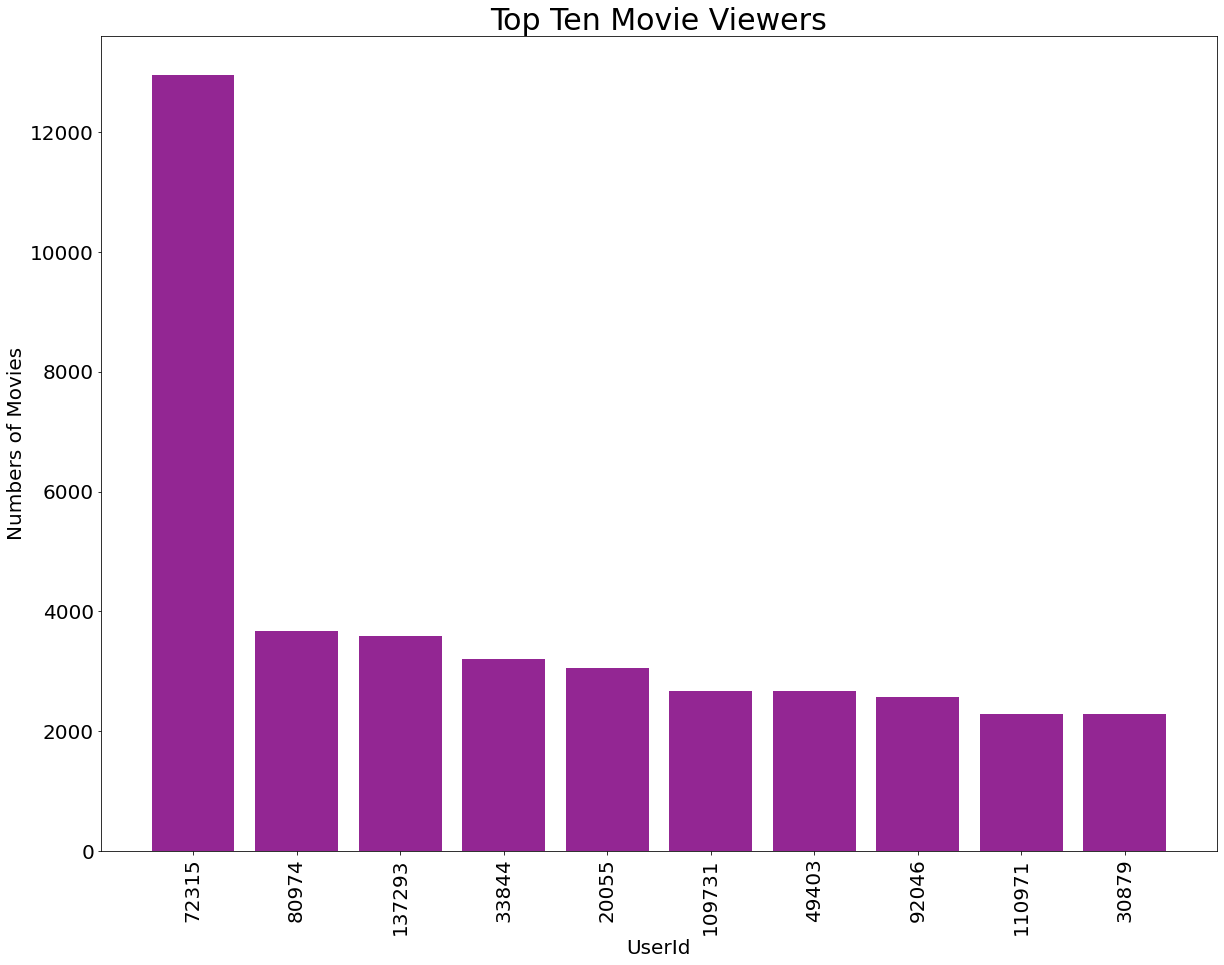

In [34]:
# Top 10 movie viewers

df_train['userId'] = df_train['userId'].astype('str')
viewers = df_train['userId'].value_counts()
fig, ax = plt.subplots( figsize=(20,15))

ax.bar(viewers.index[:10], viewers.values[:10],  color='purple', alpha=0.85, width = 0.8)
ax.set_xlabel("UserId", fontsize = 20)
ax.set_ylabel("Numbers of Movies", fontsize = 20)
ax.set_title("Top Ten Movie Viewers", fontsize = 30)
plt.xticks(rotation=90, fontsize= 20)
plt.yticks( fontsize= 20)
plt.show()

* The userId 72315 seems to be the outlier in the dataset with the highest number of views.

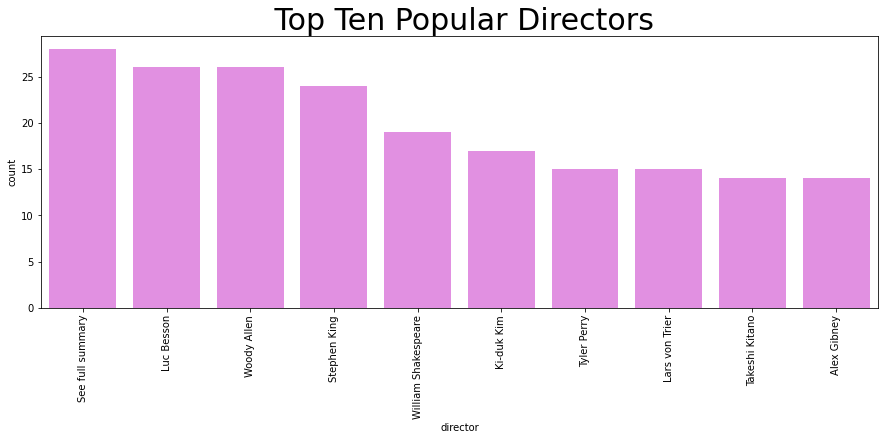

In [35]:
# Views top ten popular directors

plt.figure(figsize = (15,5))
directors=imdb['director'].explode()
ax=sns.countplot(x=directors, order = directors.value_counts().index[:10],color='violet')
ax.set_title(' Top Ten Popular Directors',fontsize=30)
plt.xticks(rotation=90)
plt.show()

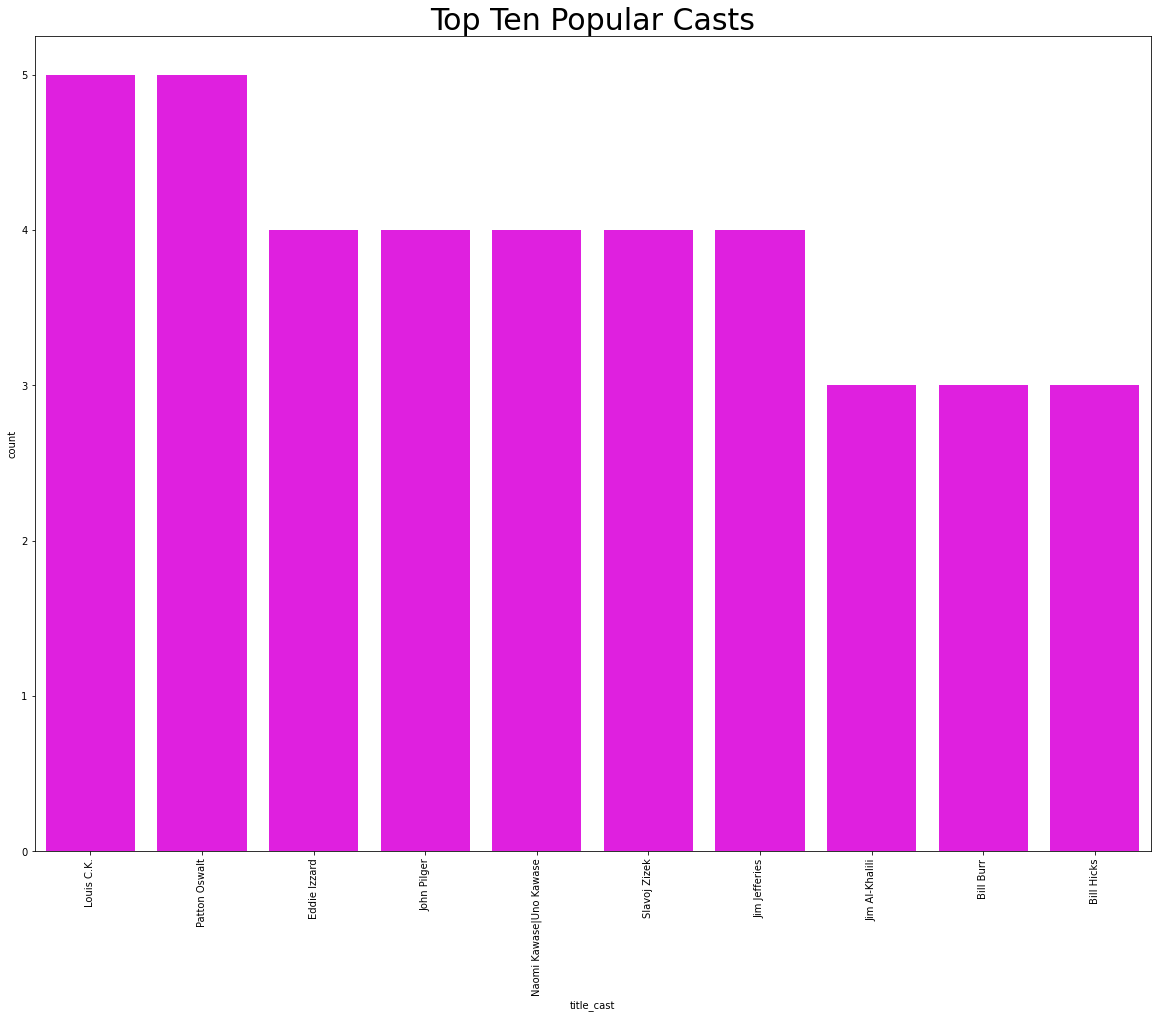

In [36]:
# views top ten popular casts
plt.figure(figsize = (20,15))
casts=imdb['title_cast'].explode()
ax=sns.countplot(x=casts, order = casts.value_counts().index[:10],color='magenta')
ax.set_title('Top Ten Popular Casts',fontsize=30)
plt.xticks(rotation=90)
plt.show()


# 5. Feature Engineering

**Feature engineering** is the process of selecting, manipulating, and transforming raw data into features that can be used in supervised learning. In order to make machine learning work well on new tasks, it might be necessary to design and train better features

In [37]:
train.shape

(10000038, 4)

In [38]:
test.shape

(14310, 2)

In [39]:
df_train = train.copy()

df_train.shape

(10000038, 4)

In [40]:
df_test = test.copy()
df_test.shape

(14310, 2)

In [41]:
df_train.sort_values(by=['userId'], inplace= True)
df_train.head()

,userId,movieId,rating,timestamp
6308822,1,296,5.0,1147880044
3137042,1,27721,3.0,1147869115
2533005,1,665,5.0,1147878820
2524478,1,4308,3.0,1147868534
1946297,1,1250,4.0,1147868414


In [42]:
test.sort_values(by=['userId'], inplace= True)
test.head()

,userId,movieId
13686,1,665
9910,1,7937
538,1,899
8676,1,2632
2257,2,1465


In [43]:
# Concatenate train and imdb tables 
df_train = df_train.merge(imdb, on = 'movieId', how= 'left')
df_train.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,1,296,5.0,1147880044,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...,Quentin Tarantino,154.0,"$8,000,000",nonlinear timeline|overdose|drug overdose|bondage
1,1,27721,3.0,1147869115,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...,Sébastien Japrisot,133.0,"$56,600,000",cracking a nut|bedridden|boot|mouse
2,1,665,5.0,1147878820,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy
3,1,4308,3.0,1147868534,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...,Baz Luhrmann,127.0,"$50,000,000",belle epoque|tragic ending|jealousy|jukebox mu...
4,1,1250,4.0,1147868414,NaN,NaN,NaN,NaN,NaN


In [44]:
# Concatenate test and imdb tables 
test = test.merge(imdb, on = 'movieId', how= 'left')
test.head()

,userId,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,665,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy
1,1,7937,NaN,NaN,NaN,NaN,NaN
2,1,899,NaN,NaN,NaN,NaN,NaN
3,1,2632,NaN,NaN,NaN,NaN,NaN
4,2,1465,Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...,Gregory Poirier,140.0,"$25,000,000",pseudohistory|train station|african american|l...


In [45]:
# Concatenate train and movies tables 
df_train = df_train.merge(movies, on = 'movieId', how= 'left')
df_train.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,296,5.0,1147880044,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...,Quentin Tarantino,154.0,"$8,000,000",nonlinear timeline|overdose|drug overdose|bondage,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,27721,3.0,1147869115,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...,Sébastien Japrisot,133.0,"$56,600,000",cracking a nut|bedridden|boot|mouse,"Very Long Engagement, A (Un long dimanche de f...",Drama|Mystery|Romance|War
2,1,665,5.0,1147878820,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy,Underground (1995),Comedy|Drama|War
3,1,4308,3.0,1147868534,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...,Baz Luhrmann,127.0,"$50,000,000",belle epoque|tragic ending|jealousy|jukebox mu...,Moulin Rouge (2001),Drama|Musical|Romance
4,1,1250,4.0,1147868414,NaN,NaN,NaN,NaN,NaN,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War


In [46]:
# Concatenate test and movies tables
test = test.merge(movies, on = 'movieId', how= 'left')
test.head()

,userId,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,665,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy,Underground (1995),Comedy|Drama|War
1,1,7937,NaN,NaN,NaN,NaN,NaN,"Silence, The (Tystnaden) (1963)",Drama
2,1,899,NaN,NaN,NaN,NaN,NaN,Singin' in the Rain (1952),Comedy|Musical|Romance
3,1,2632,NaN,NaN,NaN,NaN,NaN,"Saragossa Manuscript, The (Rekopis znaleziony ...",Adventure|Drama|Mystery
4,2,1465,Jon Voight|Ving Rhames|Don Cheadle|Bruce McGil...,Gregory Poirier,140.0,"$25,000,000",pseudohistory|train station|african american|l...,Rosewood (1997),Action|Drama


In [47]:
# Concatenate the columns listed above into a new column named key_words fot the train data
df_train['key_words'] = (pd.Series(df_train[['title_cast', 'director', 'plot_keywords', 'genres']].fillna('')
                      .values.tolist()).str.join(' '))
df_train.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres,key_words
0,1,296,5.0,1147880044,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...,Quentin Tarantino,154.0,"$8,000,000",nonlinear timeline|overdose|drug overdose|bondage,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...
1,1,27721,3.0,1147869115,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...,Sébastien Japrisot,133.0,"$56,600,000",cracking a nut|bedridden|boot|mouse,"Very Long Engagement, A (Un long dimanche de f...",Drama|Mystery|Romance|War,Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...
2,1,665,5.0,1147878820,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...,Dusan Kovacevic,170.0,"$14,000,000",magical realism|communism|zoo|black comedy,Underground (1995),Comedy|Drama|War,Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
3,1,4308,3.0,1147868534,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...,Baz Luhrmann,127.0,"$50,000,000",belle epoque|tragic ending|jealousy|jukebox mu...,Moulin Rouge (2001),Drama|Musical|Romance,Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...
4,1,1250,4.0,1147868414,NaN,NaN,NaN,NaN,NaN,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War,Adventure|Drama|War


In [48]:
# Drop the above listed columns in the train data
df_train.drop(columns=['timestamp', 'runtime', 'budget', 'title_cast', 'director', 
                           'plot_keywords','genres'], inplace= True)
df_train.head()

,userId,movieId,rating,title,key_words
0,1,296,5.0,Pulp Fiction (1994),Tim Roth|Amanda Plummer|Laura Lovelace|John Tr...
1,1,27721,3.0,"Very Long Engagement, A (Un long dimanche de f...",Audrey Tautou|Gaspard Ulliel|Dominique Pinon|C...
2,1,665,5.0,Underground (1995),Predrag 'Miki' Manojlovic|Lazar Ristovski|Mirj...
3,1,4308,3.0,Moulin Rouge (2001),Nicole Kidman|Ewan McGregor|John Leguizamo|Jim...
4,1,1250,4.0,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War


In [49]:
# Drop the above listed columns in the test data
test.drop(columns=['runtime', 'budget', 'title_cast', 'director', 
                           'plot_keywords','genres'], inplace= True)
test.head()

,userId,movieId,title
0,1,665,Underground (1995)
1,1,7937,"Silence, The (Tystnaden) (1963)"
2,1,899,Singin' in the Rain (1952)
3,1,2632,"Saragossa Manuscript, The (Rekopis znaleziony ..."
4,2,1465,Rosewood (1997)


# 5. Recommender Systems


Machine learning algorithms in recommender systems are typically classified into two categories:
* Collaborative filtering
* Content-based filtering

1. **Collaborative Filtering** is a Machine Learning technique used to identify relationships between pieces of data. This technique is frequently used in recommender systems to identify similarities between user data and items.



2. **Content-based Filtering** is a Machine Learning technique that uses similarities in features to make decisions. This technique is often used in recommender systems, which are algorithms designed to advertise or recommend things to users based on knowledge accumulated about the user.

## 5.1. Content-based filtering
CBF- will be employed using Cosine similary to make recommendations.


**Cosine similarity** is a metric used to measure how similar two items are. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The output value ranges from 0–1.

In [50]:
# Create a copy of a dataframe
df_movies = movies.copy()

In [51]:
df_new = imdb[['movieId','title_cast','director', 'plot_keywords']]
df_new = df_new.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df_new.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


In [52]:
# Change data to strings 
df_new['title_cast'] = df_new.title_cast.astype(str)
df_new['plot_keywords'] = df_new.plot_keywords.astype(str)
df_new['genres'] = df_new.genres.astype(str)
df_new['director'] = df_new.director.astype(str)

# Removing spaces between names
df_new['director'] = df_new['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df_new['title_cast'] = df_new['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Removing spaces between the actors' full names and getting only the first three names
df_new['title_cast'] = df_new['title_cast'].map(lambda x: x.split('|'))

# Removing spaces between the plot keywords' and getting only the first five words
df_new['plot_keywords'] = df_new['plot_keywords'].map(lambda x: x.split('|'))
df_new['plot_keywords'] = df_new['plot_keywords'].apply(lambda x: " ".join(x))

# Removing spaces between the genres 
df_new['genres'] = df_new['genres'].map(lambda x: x.lower().split('|'))
df_new['genres'] = df_new['genres'].apply(lambda x: " ".join(x))

df_new.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles, jimvarney, wa...",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst, br...",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren, ann-m...",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine,...",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort, kimber...",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


In [53]:
#Converting the title_cast column from list to string
df_new['liststring'] = df_new['title_cast'].apply(lambda x: ','.join(map(str, x)))

#Removing the commas between the string in each row
df_new['liststring'] = df_new['liststring'].replace(',',' ', regex=True)

#Use keywords, cast(liststring), diector and genres column to use as our features
df_features = df_new[['liststring','director','plot_keywords','genres']]

#Combine the features columns into  single string
df_new['combined_features'] = df_features['liststring'] +' '+ df_features['director'] +' '+ df_features['plot_keywords'] +' '+ df_features['genres']

#Use CountVectorizer() object for getting the cv matrix.
cv =CountVectorizer()
cv_matrix = cv.fit_transform(df_new['combined_features'])

#Getting cosine similarity matrix from the cv matrix
#Similarity_score == sim_score
sim_score = cosine_similarity(cv_matrix,cv_matrix)

df_new.set_index('title', inplace = True)
indices = pd.Series(df_new.index)

In [54]:
print(sim_score)# Simlilarity score

[[1.         0.10910895 0.07715167 ... 0.03026138 0.         0.07881104]
 [0.10910895 1.         0.         ... 0.06163336 0.         0.08025724]
 [0.07715167 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.03026138 0.06163336 0.         ... 1.         0.         0.03338903]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.07881104 0.08025724 0.         ... 0.03338903 0.         1.        ]]


In [55]:
# This method will make n recommendations based off the movie title input
def content_filter(title,n,sim_score = sim_score):
    movies_recommend = []
    
    # Index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # Series with the similarity scores in descending order
    score_series = pd.Series(sim_score[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_n_indexes = list(score_series.iloc[1:n+1].index)
    
    # populating the list with the titles of the best n matching movies
    for i in top_n_indexes:
        movies_recommend.append(list(df_new.index)[i])
        
    return movies_recommend

In [56]:
content_filter('Toy Story (1995)',10)

['Toy Story 2 (1999)',
 'Toy Story 3 (2010)',
 'Toy Story Toons: Small Fry (2011)',
 'Toy Story Toons: Hawaiian Vacation (2011)',
 "Dug's Special Mission (2009)",
 'Toy Story Toons: Partysaurus Rex (2012)',
 'Toy Story of Terror (2013)',
 'Madame Tutli-Putli (2007)',
 'Gone Nutty (2002)',
 'DuckTales: The Movie - Treasure of the Lost Lamp (1990)']

In [57]:
content_filter('Waiting to Exhale (1995)',10)

['Prime (2005)',
 'Melbourne (2014)',
 '12 Storeys (Shier lou) (1997)',
 'Opposite Day (2009)',
 'Senotaji (2013)',
 'One I Love, The (2014)',
 'Girl, The (2012)',
 'Thanks for Sharing (2012)',
 'Being Flynn (2012)',
 'Kahlekuningas (2002)']

In [58]:
content_filter('Jumanji (1995)',10)

['Zathura (2005)',
 'The Gamers: Hands of Fate (2013)',
 'Super Mario Bros. (1993)',
 'MirrorMask (2005)',
 'NeverEnding Story, The (1984)',
 'Escape to Witch Mountain (1975)',
 'Alice in Wonderland (1933)',
 'Return to Oz (1985)',
 'Brothers Lionheart, The (Bröderna Lejonhjärta) (1977)',
 "Darby O'Gill and the Little People (1959)"]

## 5.2. Collaborative Filtering

CF- technique will be employed using SVD model.

**Singular value decomposition** (SVD) is a collaborative filtering method for movie recommendation. The aim for the code implementation is to provide users with movies’ recommendation from the latent features of item-user matrices. The code would show you how to use the SVD latent factor model for matrix factorization.

**SVD default parameters**

n_factors – The number of factors. Default is **100**.

n_epochs – The number of iteration of the SGD procedure. Default is **20**.

biased (bool) – Whether to use baselines (or biases). See note above. Default is **True**.

init_mean – The mean of the normal distribution for factor vectors initialization. Default is **0**.

init_std_dev – The standard deviation of the normal distribution for factor vectors initialization. Default is **0.1**.

lr_all – The learning rate for all parameters. Default is **0.005**.

reg_all – The regularization term for all parameters. Default is **0.02**.



In [59]:
# Loading as Surprise dataframe
train_copy = df_train.copy()
reader = Reader()
# Data selected for model training
data = Dataset.load_from_df(train_copy[['userId', 'movieId', 'rating']], reader)


In [60]:
# from surprise.model_selection import train_test_split

In [61]:
# Data split 99/10
trainset, testset = train_test_split(data, test_size=0.1)

In [62]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000038 entries, 0 to 10000037
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   title      object 
 4   key_words  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 457.8+ MB


## 5.3 Data Modelling
Test dataset will used for model training and fitting

In [63]:
svd_model = SVD() #Singular Vector Decomposition

In [64]:
svd_model.fit(trainset)

In [65]:
# Making predictions using the testset
result = svd_model.test(testset) 
result

test = pd.DataFrame(result)

In [66]:
test.head()

,uid,iid,r_ui,est,details
0,156398,34542,4.0,3.577078,{'was_impossible': False}
1,86827,50,5.0,4.170964,{'was_impossible': False}
2,31145,1704,4.0,3.940007,{'was_impossible': False}
3,13442,586,3.0,2.962339,{'was_impossible': False}
4,106144,153,3.5,3.168731,{'was_impossible': False}


In [67]:
# Using list comprehension to make predictions
ratings_result=[svd_model.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]

In [68]:
# Converting our prediction into a Dataframe
df_result=pd.DataFrame(ratings_result)
df_result

,uid,iid,r_ui,est,details
0,5,788,None,3.277710,{'was_impossible': False}
1,68,7438,None,4.000328,{'was_impossible': False}
2,336,40412,None,3.849216,{'was_impossible': False}
3,803,3822,None,3.807803,{'was_impossible': False}
4,547,903,None,4.545348,{'was_impossible': False}
...,...,...,...,...,...
14305,294,30707,None,3.621319,{'was_impossible': False}
14306,803,780,None,2.572252,{'was_impossible': False}
14307,519,912,None,4.173812,{'was_impossible': False}
14308,628,6764,None,3.274656,{'was_impossible': False}


In [69]:
# Renaming our predictions to original names
df_result=df_result.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_result.drop(['r_ui','details'],axis=1,inplace=True)


In [70]:
df_result.head() #Renamed Dataframe featutres

,userId,movieId,rating
0,5,788,3.277710
1,68,7438,4.000328
2,336,40412,3.849216
3,803,3822,3.807803
4,547,903,4.545348


In [71]:
# Concatenating userId/movieId into a single Id column

for i in range(2):
    df_result['Id']=df_result.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [72]:
# Drop the columns: 'userId' and 'movieId'
df_result.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [73]:
# View the predicted dataset
df_result = df_result[['Id', 'rating']]

In [74]:
# View the first 5 rows
df_result.head(5)

,Id,rating
0,5_788,3.277710
1,68_7438,4.000328
2,336_40412,3.849216
3,803_3822,3.807803
4,547_903,4.545348


In [75]:
# View the shape of Dataframe for submission conformance
df_result.shape

(14310, 2)

In [76]:
# Submission csv file using svd model in default mode
df_result.to_csv("kaggle_submission", index=False)

## 5.3 RMSE scores using Default SVD Model

The following respective RSME Scores were obtained on kaggle:

First Submission: RMSE score = **0.65890** 

Second Submission: RMSE score = **0.66398**

Third Submission: RMSE score = **0.66603**



# 6. Hyperparameter Tuning

**Hyperparameter tuning** is choosing a set of optimal hyperparameters for a learning algorithm.
A hyperparameter is a model argument whose value is set before the learning process begins. The key to machine learning algorithms is hyperparameter tuning.

svd_model parameters will be tuned from default to obtain the least RMSE.

In [77]:
# Loading as Surprise dataframe
train_copy = df_train.copy()
reader = Reader(rating_scale=(0, 5))
# Data for training the SVD model
data = Dataset.load_from_df(train_copy[['userId', 'movieId', 'rating']], reader)

In [78]:
# The full dataset for model training
tun_train = data.build_full_trainset()
# The parameters obtained from randomised search CV
svd_model = SVD(n_factors = 300 , lr_all = 0.007 , reg_all = 0.04 , n_epochs = 80 , init_std_dev = 0.03)
# Fit the model
svd_model.fit(tun_train)

In [79]:
# Using list comprehension to make predictions
ratings_result=[svd_model.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]
# View the predictions
#ratings_predictions

In [80]:
# Converting our prediction into a familiar format-Dataframe
df_result=pd.DataFrame(ratings_result)
# View the predictions from a dataframe
df_result

,uid,iid,r_ui,est,details
0,5,788,None,2.830801,{'was_impossible': False}
1,68,7438,None,4.034780,{'was_impossible': False}
2,336,40412,None,4.224312,{'was_impossible': False}
3,803,3822,None,3.943844,{'was_impossible': False}
4,547,903,None,4.437797,{'was_impossible': False}
...,...,...,...,...,...
14305,294,30707,None,3.669552,{'was_impossible': False}
14306,803,780,None,2.594813,{'was_impossible': False}
14307,519,912,None,4.077924,{'was_impossible': False}
14308,628,6764,None,3.274553,{'was_impossible': False}


In [81]:
# Renaming our predictions to original names
df_result=df_result.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
# Drop the columns not required for the submission
df_result.drop(['r_ui','details'],axis=1,inplace=True)

In [82]:
# Dataframe features
df_result.head()

,userId,movieId,rating
0,5,788,2.830801
1,68,7438,4.034780
2,336,40412,4.224312
3,803,3822,3.943844
4,547,903,4.437797


In [83]:
# Concatenating userId/movieId into a single Id column

for i in range(2):
    df_result['Id']=df_result.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [84]:
# View the top 5 rows for the prediction
df_result.head()

,userId,movieId,rating,Id
0,5,788,2.830801,5_788
1,68,7438,4.034780,68_7438
2,336,40412,4.224312,336_40412
3,803,3822,3.943844,803_3822
4,547,903,4.437797,547_903


In [85]:
# Drop the features not be required for the submission
df_result.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [86]:
# Datframe required for submission
df_result = df_result[['Id', 'rating']]

In [87]:
df_result.head()

,Id,rating
0,5_788,2.830801
1,68_7438,4.034780
2,336_40412,4.224312
3,803_3822,3.943844
4,547_903,4.437797


In [ ]:
# Dataframe orientation
df_result.shape

In [89]:
# Submission csv file hyperparameter tuning of parameters
df_result.to_csv("kaggle_submission_hyperparameter_tuned_1", index=False)

## 6.1 RMSE scores using Hyperparameter Tuned SVD Model

The following respective RSME Scores were obtained on kaggle:

First Submission: RMSE score = **0.49898** 

Second Submission: RMSE score = **0.50919**

Third Submission: RMSE score = **0.44525**




## 6.2 Model Performance and Evaluation

Based on the project requirements, Collaborative Filtering performed very well using SVD Model with hyperparameter tuning.

